<font size="1">
Supplementary code for "Build a Large Language Model From Scratch": <a href="https://www.manning.com/books/build-a-large-language-model-from-scratch">https://www.manning.com/books/build-a-large-language-model-from-scratch</a> by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>

## Appendix D: Adding Bells and Whistles to the Training Loop

- In this appendix, we add a few more advanced features to the training function, which are used in typical pretraining and finetuning; finetuning is covered in chapters 6 and 7
- The next three sections below discuss learning rate warmup, cosine decay, and gradient clipping
- The final section adds these techniques to the training function

- We start by initializing a model reusing the code from chapter 5:

In [1]:
from importlib.metadata import version
import torch

print("torch version:", version("torch"))


from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

torch version: 2.2.2


- Next, using the same code we used in chapter 5, we initialize the data loaders:

In [2]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [3]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

## D.1 Learning rate warmup

- When training complex models like LLMs, implementing learning rate warmup can help stabilize the training
- In learning rate warmup, we gradually increase the learning rate from a very low value (`initial_lr`) to a user-specified maximum (`peak_lr`)
- This way, the model will start the training with small weight updates, which helps decrease the risk of large destabilizing updates during the training

In [4]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

- Typically, the number of warmup steps is between 10% and 20% of the total number of steps
- We can compute the increment as the difference between the `peak_lr` and `initial_lr` divided by the number of warmup steps

In [5]:
warmup_steps = 20
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights
        # ...

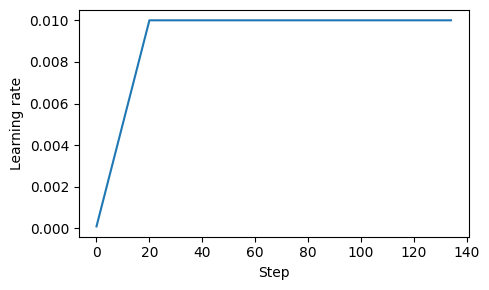

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("1.pdf")
plt.show()

## D.2 Cosine decay

- Another popular technique for training complex deep neural networks is cosine decay, which also adjusts the learning rate across training epochs
- In cosine decay, the learning rate follows a cosine curve, decreasing from its initial value to near zero following a half-cosine cycle
- This gradual reduction is designed to slow the pace of learning as the model begins to improve its weights; it reduces the risk of overshooting minima as the training progresses,  which is crucial for stabilizing the training in its later stages
- Cosine decay is often preferred over linear decay for its smoother transition in learning rate adjustments, but linear decay is also used in practice (for example, [OLMo: Accelerating the Science of Language Models](https://arxiv.org/abs/2402.00838))

In [7]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        # Adjust the learning rate based on the current phase (warmup or cosine annealing)
        if global_step < warmup_steps:
            # Linear warmup
            lr = initial_lr + global_step * lr_increment  
        else:
            # Cosine annealing after warmup
            progress = ((global_step - warmup_steps) / 
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights

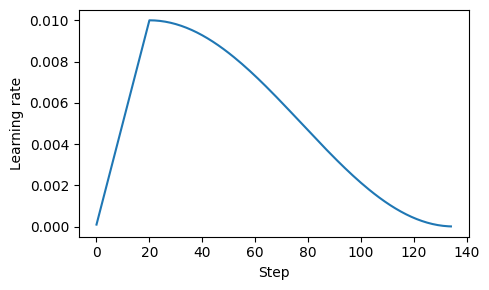

In [8]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("2.pdf")
plt.show()

## D.3 Gradient clipping

- Gradient clipping is yet another technique used to stabilize the training when training LLMs
- By setting a threshold, gradients exceeding this limit are scaled down to a maximum magnitude to ensure that the updates to the model's parameters during backpropagation remain within a manageable range
- For instance, using the `max_norm=1.0` setting in PyTorch's `clip_grad_norm_` method means that the norm of the gradients is clipped such that their maximum norm does not exceed 1.0
- the "norm" refers to a measure of the gradient vector's length (or magnitude) in the parameter space of the model
- Specifically, it's the L2 norm, also known as the Euclidean norm
- Mathematically, for a vector $\mathbf{v}$ with components $\mathbf{v} = [v_1, v_2, \ldots, v_n]$, the L2 norm is defined as:
$$
\| \mathbf{v} \|_2 = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$

- The L2 norm is calculated similarly for matrices.
- Let's assume our gradient matrix is:
$$
G = \begin{bmatrix}
1 & 2 \\
2 & 4
\end{bmatrix}
$$

- And we want to clip these gradients with a `max_norm` of 1.

- First, we calculate the L2 norm of these gradients:
$$
\|G\|_2 = \sqrt{1^2 + 2^2 + 2^2 + 4^2} = \sqrt{25} = 5
$$

- Since $\|G\|_2 = 5$ is greater than our `max_norm` of 1, we need to scale down the gradients so that their norm is exactly 1. The scaling factor is calculated as $\frac{max\_norm}{\|G\|_2} = \frac{1}{5}$.

- Therefore, the scaled gradient matrix $G'$ will be as follows:
$$
G' = \frac{1}{5} \times G = \begin{bmatrix}
\frac{1}{5} & \frac{2}{5} \\
\frac{2}{5} & \frac{4}{5}
\end{bmatrix}
$$

- Let's see this in action
- First, we initialize a new model and calculate the loss for a training batch like we would do in the regular training loop

In [9]:
from previous_chapters import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

- If we call `.backward()`, PyTorch will calculate the gradients and store them in a `.grad` attribute for each weight (parameter) matrix
- Let's define a utility function to calculate the highest gradient based on all model weights

In [10]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0411)


- Applying gradient clipping, we can see that the largest gradient is now substantially smaller:

In [11]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0185)


## D.4 The modified training function

- Now let's add the three concepts covered above (learning rate warmup, cosine decay, and gradient clipping) to the `train_model_simple` function covered in chapter 5 to create the more sophisticated `train_model` function below:

In [12]:
from previous_chapters import evaluate_model, generate_and_print_sample


def train_model(model, train_loader, val_loader, optimizer, device, n_epochs,
                eval_freq, eval_iter, start_context, tokenizer, warmup_steps=10,
                initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the maximum learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Linear warmup
                lr = initial_lr + global_step * lr_increment  
            else:
                # Cosine annealing after warmup
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # Calculate and backpropagate the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # Apply gradient clipping after the warmup phase to avoid exploding gradients
            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs

In [13]:
import tiktoken

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=10, initial_lr=1e-5, min_lr=1e-5
)

Ep 1 (Iter 000000): Train loss 10.934, Val loss 10.939
Ep 1 (Iter 000005): Train loss 8.529, Val loss 8.843
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 6.400, Val loss 6.825
Ep 2 (Iter 000015): Train loss 6.116, Val loss 6.861
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.033, Val loss 6.904
Ep 3 (Iter 000025): Train loss 5.915, Val loss 6.851
Every effort moves you, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the
Ep 4 (Iter 000030): Train loss 5.375, Val loss 6.815
Ep 4 (Iter 000035): Train loss 5.001, Val loss 6.701
Every effort moves you.                                                 
Ep 5 (Iter 000040): Train loss 4.993, Val loss 6.641
Every effort moves you of the                                                
Ep 6 (Iter 000045): Train loss 3.872, Val loss 6.508
Ep 6 (Iter 000050): Tra

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas, towards the end, it's able to produce grammatically more or less correct sentences
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data
- Note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load the pretrained weights

- A quick check that the learning rate behaves as intended

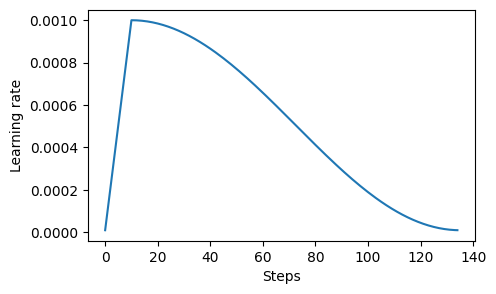

In [14]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

- And a quick look at the loss curves

/var/folders/jg/tpqyh1fd5js5wsr1d138k3n40000gn/T/ipykernel_9436/3589549395.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout(); plt.savefig("3.pdf")


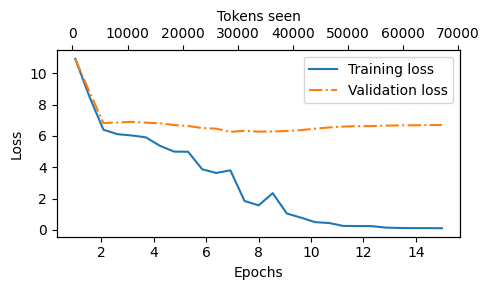

In [15]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout(); plt.savefig("3.pdf")
plt.show()

- Note that the model is overfitting here because the dataset is kept very small for educational purposes (so that the code can be executed on a laptop computer)
- For a longer pretraining run on a much larger dataset, see [../../ch05/03_bonus_pretraining_on_gutenberg](../../ch05/03_bonus_pretraining_on_gutenberg)